In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***`Libraries`***

In [159]:
!pip install --upgrade mlxtend
!pip install kmodes
!pip install kneed
!pip install ace_tools # Install the missing module 'ace_tools' using pip.


In [160]:
from mlxtend.frequent_patterns import fpgrowth
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator


In [161]:
import warnings
warnings.filterwarnings("ignore")

# ***`Read Data`***

In [162]:
# Đây là 2 bảng dữ liệu đã được chuẩn hóa sạch sẽ
df_continuous = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/DataFeatures(Continuous).xlsx')
df_categorical = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/DataFeatures(Categorical).xlsx')
df_continuous_old = df_continuous.iloc[:, :10]
df_continuous_old = df_continuous_old.drop(columns=['Unnamed: 0'])
df_continuous_new = df_continuous.iloc[:, 10:]

# ***`DEF WCSS, GDI 2-2`***

In [163]:
# Tính toán WCSS (Within-Cluster Sum of Squares)
def calculate_wcss(data, labels, centers):
    wcss = 0
    for i, center in enumerate(centers):
        cluster_points = data[labels == i]
        wcss += np.sum(np.square(cdist(cluster_points, [center], 'euclidean')))
    return wcss

In [164]:
# Tính toán GDI 2-2 (Generalized Dunn Index)
def generalized_dunn_index(data, labels, centers):
    num_clusters = len(centers)
    min_intercluster_distance = np.inf
    max_intracluster_distance = 0

    for i in range(num_clusters):
        # Kiểm tra xem cụm có rỗng hay không
        cluster_points = data[labels == i]
        if len(cluster_points) == 0:
            continue  # Bỏ qua các cụm rỗng

        for j in range(i + 1, num_clusters):
            intercluster_distance = np.linalg.norm(centers[i] - centers[j])
            min_intercluster_distance = min(min_intercluster_distance, intercluster_distance)

        # Chỉ tính khoảng cách trong cụm nếu cụm không rỗng
        intracluster_distances = cdist(cluster_points, [centers[i]], 'euclidean')
        if len(intracluster_distances) > 0:
            max_intracluster_distance = max(max_intracluster_distance, np.max(intracluster_distances))

    # Tránh chia cho 0 nếu không có cụm hợp lệ
    if max_intracluster_distance == 0:
        return np.inf  # Hoặc một giá trị phù hợp khác cho trường hợp đặc biệt này

    return min_intercluster_distance / max_intracluster_distance


# ***`Trước khi xử dụng Frequent Itemset`***

In [165]:
df_continuous_old = df_continuous.iloc[:, :10]
df_continuous_old = df_continuous_old.drop(columns=['Unnamed: 0'])
df_continuous_old.head(2)

,revenue,positive,negative,Year_Joined,Shop_Rating,Followers,Chat Resopnse,total_feedback,Counter_Rating
0,-1.069676,0.749170,-0.729040,-0.277422,0.614897,0.490382,-0.868164,0.285696,-0.091406
1,0.555398,-0.506968,0.523543,-0.970571,0.614897,0.771941,-0.868164,0.581779,0.073333


Threshold: 0.1, Silhouette Score: 0.18125826883789778
Threshold: 0.2, Silhouette Score: 0.15494899635857623
Threshold: 0.3, Silhouette Score: 0.18701619224512706
Threshold: 0.4, Silhouette Score: 0.1858587472212154
Threshold: 0.5, Silhouette Score: 0.1800682702365975
Threshold: 0.6, Silhouette Score: 0.1590317711655872
Threshold: 0.7, Silhouette Score: 0.17558135780311152
Threshold: 0.8, Silhouette Score: 0.16439284475118643
Threshold: 0.9, Silhouette Score: 0.18662258599978826
Threshold: 1.0, Silhouette Score: 0.18569850522969014


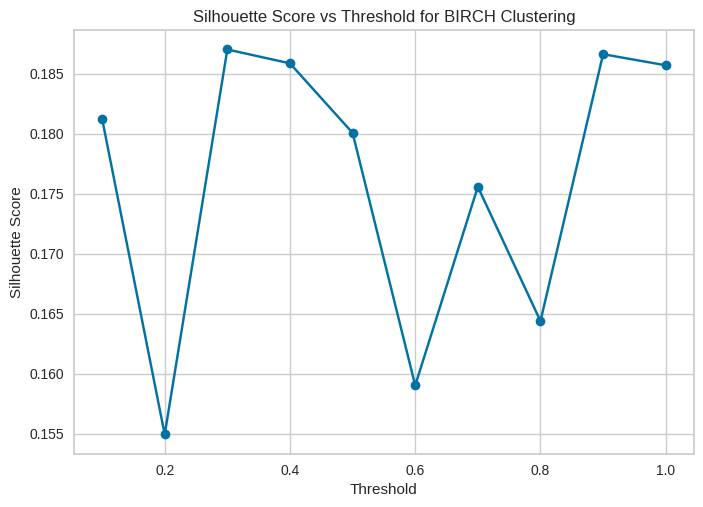

In [166]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Giả sử 'data' là tập dữ liệu đã chuẩn bị sẵn (normalized data)
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
silhouette_scores = []
valid_thresholds = [] # Create a new list to store the thresholds for which silhouette scores were calculated

# Thử nghiệm với nhiều giá trị threshold khác nhau
for t in thresholds:
    birch_model = Birch(threshold=t)
    birch_model.fit(df_continuous_old)

    # Lấy nhãn phân cụm
    labels = birch_model.labels_

    # Kiểm tra xem có nhiều hơn 1 cluster không
    if len(set(labels)) > 1:  # Check for more than 1 unique label
        # Tính toán Silhouette Score nếu có nhiều hơn 1 cluster
        score = silhouette_score(df_continuous_old, labels)
        silhouette_scores.append(score)
        valid_thresholds.append(t) # Append the valid threshold
        print(f"Threshold: {t}, Silhouette Score: {score}")
    else:
        print(f"Threshold: {t}, Only one cluster found. Skipping Silhouette Score calculation.")

# Vẽ biểu đồ Silhouette Score theo các giá trị threshold
# Use valid_thresholds instead of thresholds for plotting
plt.plot(valid_thresholds, silhouette_scores, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Threshold for BIRCH Clustering")
plt.show()

Silhouette Score cho threshold = 0.3: 0.18701619224512706
Davies-Bouldin Index: 1.6389094377608557
WCSS: 13473.045672302094
GDI 2-2: 0.09897579676948862


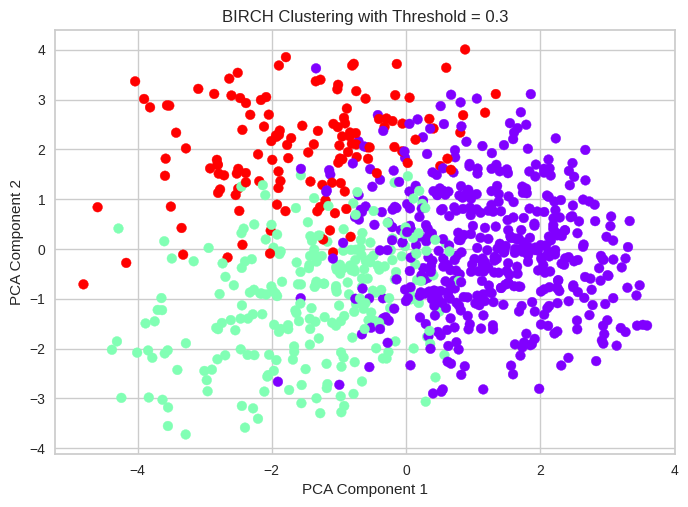

Số lượng cụm: 3


In [167]:
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Giả sử 'data' là tập dữ liệu đã chuẩn bị và chuẩn hóa
# Tạo mô hình BIRCH với threshold = 0.4
birch_model = Birch(threshold=0.3)

# Huấn luyện mô hình với dữ liệu
birch_model.fit(df_continuous_old)

# Lấy nhãn của các cụm
labels = birch_model.labels_

# Tính toán Silhouette Score cho đánh giá phân cụm
silhouette_avg = silhouette_score(df_continuous_old, labels)
print(f'Silhouette Score cho threshold = 0.3: {silhouette_avg}')

# Tính toán Davies-Bouldin Index (DBI)
dbi_score = davies_bouldin_score(df_continuous_old, labels)
print(f'Davies-Bouldin Index: {dbi_score}')

# WCSS
centers = birch_model.subcluster_centers_
wcss = calculate_wcss(df_continuous_old, labels, centers)
print(f'WCSS: {wcss}')

# GDI 2-2
gdi_2_2 = generalized_dunn_index(df_continuous_old, labels, centers)
print(f'GDI 2-2: {gdi_2_2}')

# Giảm chiều dữ liệu bằng PCA để trực quan hóa
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_continuous_old)

# Vẽ biểu đồ phân cụm
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='rainbow')
plt.title('BIRCH Clustering with Threshold = 0.3')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Kiểm tra số lượng cụm được tạo ra
num_clusters = len(set(labels))
print(f'Số lượng cụm: {num_clusters}')


In [168]:
def calculate_k_distance(X, min_samples):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)
    distances = np.sort(distances[:, min_samples - 1], axis=0)
    return distances

def select_eps_from_knee(distances):
    kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
    eps = distances[kneedle.elbow]
    return eps

def x_dbscan(X, min_samples_list):
    best_eps = None
    best_minPts = None
    best_score = -1
    best_model = None

    for idx, min_samples in enumerate(min_samples_list):
        print(f"Evaluating for min_samples = {min_samples}...")
        distances = calculate_k_distance(X, min_samples)
        eps = select_eps_from_knee(distances)

        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = dbscan_model.labels_

        if len(set(labels)) > 1 and len(set(labels)) < len(X):
            score = silhouette_score(X, labels)
            print(f"Silhouette Score for min_samples={min_samples}, eps={eps}: {score}")

            if score > best_score:
                best_eps = eps
                best_minPts = min_samples
                best_score = score
                best_model = dbscan_model

    print(f"Best eps: {best_eps}, Best min_samples: {best_minPts}, Best Silhouette Score: {best_score}")

    if best_model is not None:
        labels = best_model.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f"Number of clusters: {n_clusters}")
        print(f"Number of noise points: {n_noise}")

    return best_model

# Tạo dữ liệu mẫu
X = df_continuous_old

# Chạy X-DBSCAN với danh sách các giá trị min_samples khác nhau
min_samples_list = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
best_model = x_dbscan(X, min_samples_list)


Evaluating for min_samples = 10...
Silhouette Score for min_samples=10, eps=2.519242537998768: 0.28540737103747893
Evaluating for min_samples = 11...
Silhouette Score for min_samples=11, eps=2.5378863996820207: 0.28540737103747893
Evaluating for min_samples = 12...
Silhouette Score for min_samples=12, eps=2.851586081706271: 0.278308861334118
Evaluating for min_samples = 13...
Silhouette Score for min_samples=13, eps=2.860309660352109: 0.278308861334118
Evaluating for min_samples = 14...
Silhouette Score for min_samples=14, eps=2.552329779015013: 0.30285026379195057
Evaluating for min_samples = 15...
Silhouette Score for min_samples=15, eps=2.577669225900468: 0.30285026379195057
Evaluating for min_samples = 16...
Silhouette Score for min_samples=16, eps=3.07487212400632: 0.30158631173651984
Evaluating for min_samples = 17...
Silhouette Score for min_samples=17, eps=2.63672226747382: 0.32041170372618943
Evaluating for min_samples = 18...
Silhouette Score for min_samples=18, eps=2.8086054

Silhouette Score: 0.21502311522147932


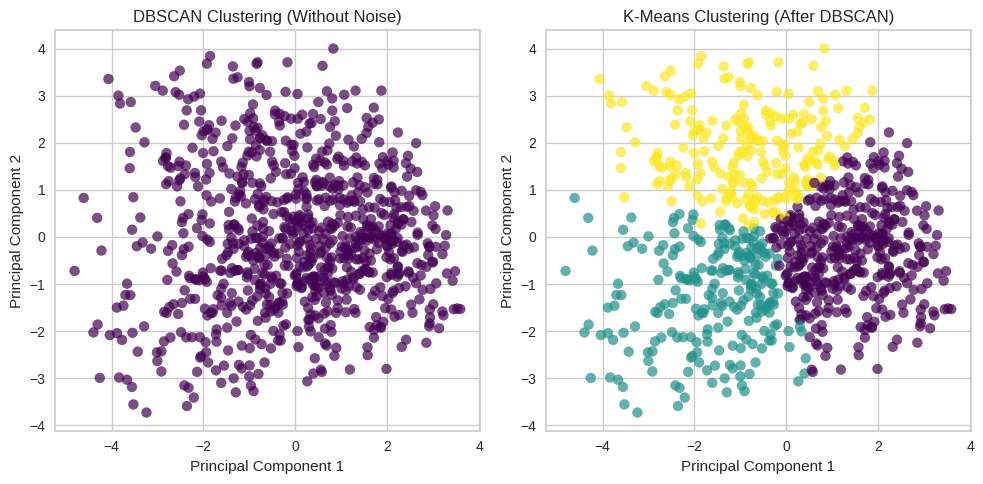

{0: 393, 1: 236, 2: 222}

In [169]:
# Loại bỏ các điểm nhiễu (noise), tức là các điểm có nhãn -1
non_noise_mask = best_model.labels_ != -1
X_non_noise = X[non_noise_mask]

dbscan_labels = best_model.labels_  # Add this line


# Bước 2: Áp dụng K-Means trên các điểm không nhiễu
kmeans = KMeans(n_clusters=3, random_state=42)  # Điều chỉnh số cụm theo ý muốn
kmeans_labels = kmeans.fit_predict(X_non_noise)



# Step 3: Calculate silhouette score for K-Means clustering
silhouette_avg = silhouette_score(X_non_noise, kmeans_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Visualization với PCA cho cả hai bước

# Giảm chiều dữ liệu cho visualization (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise)

# Visualization DBSCAN
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels[non_noise_mask], cmap='viridis', s=50, alpha=0.7)
plt.title('DBSCAN Clustering (Without Noise)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Visualization K-Means
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('K-Means Clustering (After DBSCAN)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

# Thông tin về cụm từ K-Means
unique_labels, counts = np.unique(kmeans_labels, return_counts=True)
clusters_info = dict(zip(unique_labels, counts))
clusters_info

# ***`Sau khi sử dụng Frequent Itemset`***

In [170]:
# Initialize
selected_features = df_continuous_old.copy()  # Bắt đầu với các biến liên tục
best_cost = np.inf  # Khởi tạo với giá trị cost cao nhất có thể
binary_features = df_continuous_new.copy()  # Danh sách các biến nhị phân mới

while len(binary_features.columns) > 0:
    best_feature = None
    for binary_feature_name in binary_features.columns:
        # Thêm biến nhị phân hiện tại vào bộ dữ liệu
        current_features = selected_features.copy()
        current_features[binary_feature_name] = binary_features[binary_feature_name]

        # Thực hiện phân cụm K-Prototypes
        kproto = KPrototypes(n_clusters=3, init = 'Cao', random_state=42)  # Điều chỉnh số cụm tùy ý
        categorical_columns = list(range(len(selected_features.columns), len(current_features.columns)))  # Định nghĩa các cột nhị phân
        kproto.fit(current_features, categorical=categorical_columns)

        # Lấy cost của mô hình
        current_cost = kproto.cost_

        # Kiểm tra nếu cost giảm thì giữ lại biến nhị phân tốt nhất
        if current_cost < best_cost:
            best_cost = current_cost
            best_feature = binary_feature_name

    # Nếu không có biến nhị phân nào cải thiện cost, dừng quá trình
    if best_feature is None:
        break

    # Thêm biến nhị phân tốt nhất vào bộ feature đã chọn
    selected_features[best_feature] = binary_features[best_feature]

    # Loại bỏ biến nhị phân đã được chọn khỏi danh sách các feature còn lại
    binary_features = binary_features.drop(columns=[best_feature])

# In ra các feature đã được chọn và cost tốt nhất
print("Selected features: ", selected_features.columns)
print("Best cost: ", best_cost)


Selected features:  Index(['revenue', 'positive', 'negative', 'Year_Joined', 'Shop_Rating',
       'Followers', 'Chat Resopnse', 'total_feedback', 'Counter_Rating',
       'positive_Low_negative_High'],
      dtype='object')
Best cost:  4966.559381309564


In [171]:
features_name = ['revenue', 'positive', 'negative', 'Year_Joined', 'Shop_Rating',
       'Followers', 'Chat Resopnse', 'total_feedback', 'Counter_Rating',
       'positive_Low_negative_High']
df_continuous_final = df_continuous[features_name]
df_continuous_final.head(2)

,revenue,positive,negative,Year_Joined,Shop_Rating,Followers,Chat Resopnse,total_feedback,Counter_Rating,positive_Low_negative_High
0,-1.069676,0.749170,-0.729040,-0.277422,0.614897,0.490382,-0.868164,0.285696,-0.091406,0
1,0.555398,-0.506968,0.523543,-0.970571,0.614897,0.771941,-0.868164,0.581779,0.073333,0


In [172]:
def calculate_k_distance(X, min_samples):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)
    distances = np.sort(distances[:, min_samples - 1], axis=0)
    return distances

def select_eps_from_knee(distances):
    kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
    eps = distances[kneedle.elbow]
    return eps

def x_dbscan(X, min_samples_list):
    best_eps = None
    best_minPts = None
    best_score = -1
    best_model = None

    for idx, min_samples in enumerate(min_samples_list):
        print(f"Evaluating for min_samples = {min_samples}...")
        distances = calculate_k_distance(X, min_samples)
        eps = select_eps_from_knee(distances)

        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = dbscan_model.labels_

        if len(set(labels)) > 1 and len(set(labels)) < len(X):
            score = silhouette_score(X, labels)
            print(f"Silhouette Score for min_samples={min_samples}, eps={eps}: {score}")

            if score > best_score:
                best_eps = eps
                best_minPts = min_samples
                best_score = score
                best_model = dbscan_model

    print(f"Best eps: {best_eps}, Best min_samples: {best_minPts}, Best Silhouette Score: {best_score}")

    if best_model is not None:
        labels = best_model.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f"Number of clusters: {n_clusters}")
        print(f"Number of noise points: {n_noise}")

    return best_model

# Tạo dữ liệu mẫu
X = df_continuous_final

# Chạy X-DBSCAN với danh sách các giá trị min_samples khác nhau
min_samples_list = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
best_model = x_dbscan(X, min_samples_list)


Evaluating for min_samples = 10...
Silhouette Score for min_samples=10, eps=2.519242537998768: 0.274782571867042
Evaluating for min_samples = 11...
Silhouette Score for min_samples=11, eps=2.682301800992817: 0.2970650039552297
Evaluating for min_samples = 12...
Silhouette Score for min_samples=12, eps=2.8549168208919866: 0.2734348315961984
Evaluating for min_samples = 13...
Silhouette Score for min_samples=13, eps=2.860309660352109: 0.2734348315961984
Evaluating for min_samples = 14...
Silhouette Score for min_samples=14, eps=2.874314010431191: 0.2734348315961984
Evaluating for min_samples = 15...
Silhouette Score for min_samples=15, eps=2.577669225900468: 0.2982429089018137
Evaluating for min_samples = 16...
Silhouette Score for min_samples=16, eps=2.780175337141488: 0.2970650039552297
Evaluating for min_samples = 17...
Silhouette Score for min_samples=17, eps=2.722470958491199: 0.31613588413202054
Evaluating for min_samples = 18...
Silhouette Score for min_samples=18, eps=2.808605434

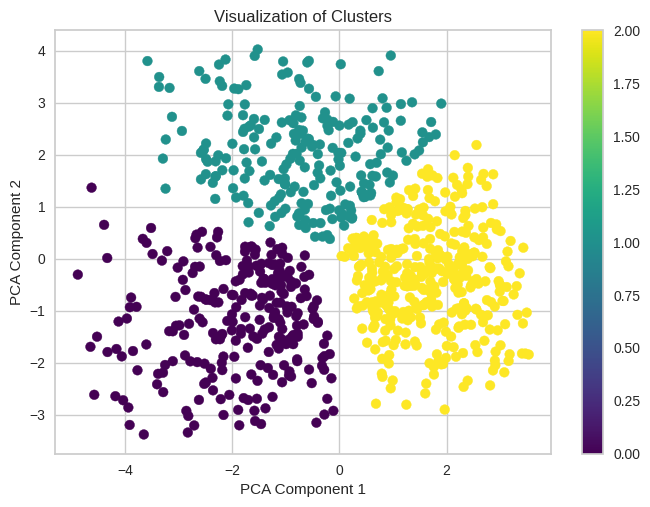

Cost của K-Prototypes: 4827.208325722807


In [173]:
import pandas as pd
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Loại bỏ các điểm nhiễu
non_noise_mask = dbscan_labels != -1
X_non_noise = X[non_noise_mask]

categorical_columns_indices = [9]

# Áp dụng K-Prototypes
kproto = KPrototypes(n_clusters=3, init='Cao', random_state=42)
clusters = kproto.fit_predict(X_non_noise, categorical=categorical_columns_indices)

# Tính cost của K-Prototypes
kproto_cost = kproto.cost_

# Thêm nhãn cụm vào DataFrame
X_non_noise['Cluster'] = clusters

# Giảm dữ liệu xuống 2 chiều bằng PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_non_noise)

# Vẽ biểu đồ
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

print(f"Cost của K-Prototypes: {kproto_cost}")


# ***`Cluster Profiling`***

In [174]:
import pandas as pd

# Giả sử dữ liệu X_non_noise sau khi phân cụm đã có cột 'Cluster'
# và categorical_columns_indices là danh sách các cột phân loại

# Đầu tiên, tạo ra các DataFrame riêng cho từng loại biến
continuous_columns = [col for col in X_non_noise.columns if col not in categorical_columns_indices + ['Cluster']]
categorical_columns = [col for col in categorical_columns_indices]

# Tạo DataFrame để chứa các thông tin về profile của mỗi cụm
cluster_profile = pd.DataFrame()

# Phân tích các đặc trưng liên tục
for col in continuous_columns:
    cluster_profile[f"{col}_mean"] = X_non_noise.groupby('Cluster')[col].mean()

for col_index in categorical_columns_indices:  # Iterate through indices
    col_name = X_non_noise.columns[col_index]  # Get the actual column name
    cluster_profile[f"{col_name}_mode"] = X_non_noise.groupby('Cluster')[col_name].agg(lambda x: x.mode()[0])



# Thêm số lượng mẫu trong mỗi cụm
cluster_profile['Cluster_size'] = X_non_noise['Cluster'].value_counts()

cluster_profile = pd.DataFrame(cluster_profile)
cluster_profile


,revenue_mean,positive_mean,negative_mean,Year_Joined_mean,Shop_Rating_mean,Followers_mean,Chat Resopnse_mean,total_feedback_mean,Counter_Rating_mean,positive_Low_negative_High_mean,positive_Low_negative_High_mode,Cluster_size
Cluster,,,,,,,,,,,,
0,-0.633905,0.740153,-0.735932,-0.358969,0.415662,-0.698330,-0.560845,-0.697252,-0.802825,0.007843,0,255
1,-0.204305,-1.233440,1.237499,0.045196,-0.859589,-0.410082,-0.283056,-0.370399,-0.255592,0.838710,1,217
2,0.529624,0.221648,-0.204398,0.240155,0.219877,0.729976,0.533083,0.697484,0.721467,0.100264,0,379
